In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os
from datetime import timedelta

In [45]:
#Download Index data from YahooFinance
indexes = ["^GSPC", "^FTLC", "^HSI", "^N225", "000001.SS", "^SSMI", "^BSESN", "^GDAXI", "^FCHI", "^BVSP"]
all_index_df = pd.DataFrame()
all_index_original_df = pd.DataFrame()
path = "./data/index/"
for index in indexes:
    index_df = yf.download(tickers=index, start="1999-01-01", end="2019-12-31", interval="1d")
    index_df = index_df.drop(columns=['Open', 'High', 'Low', 'Close'])
    
    # Calculate percentage change for 'Adj Close' and 'Volume'
    index_df['date'] = index_df.index
    index_df['price_change'] = index_df['Adj Close'].pct_change()
    index_df['volume_change'] = index_df['Volume'].pct_change()
    index_df['volatility'] = index_df['Adj Close'].rolling(window=252).std()
    index_df.loc[index_df['Volume'] == 0, 'volume_change'] = 0
    
    # Rename columns
    index_df.rename(columns = {'Adj Close':'price', 'Volume': 'volume'}, inplace = True)
    
    # Save index data to csv
    index_df.to_csv(path + f"{index}_index.csv", index=False)
    print(f"Saved {index}_index.csv")
    
    index_df['index'] = index
    all_index_df = pd.concat([all_index_df, index_df], ignore_index=True)

# Save aggregated index data to csv
all_index_df.to_csv(path + f"all_index.csv", index=False)
print(f"Saved all_index.csv")
    

[*********************100%***********************]  1 of 1 completed
Saved ^GSPC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FTLC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^HSI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^N225_index.csv
[*********************100%***********************]  1 of 1 completed
Saved 000001.SS_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^SSMI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BSESN_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^GDAXI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FCHI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BVSP_index.csv
Saved all_index.csv


## Return

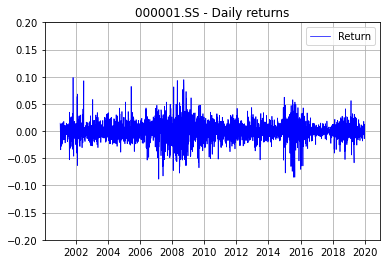

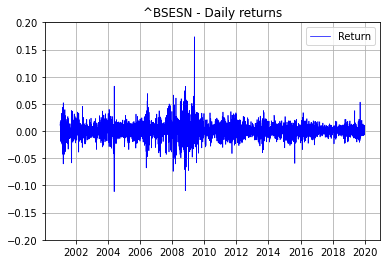

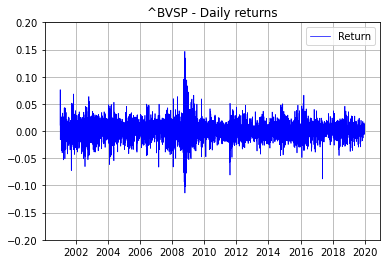

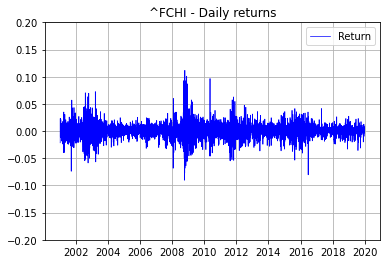

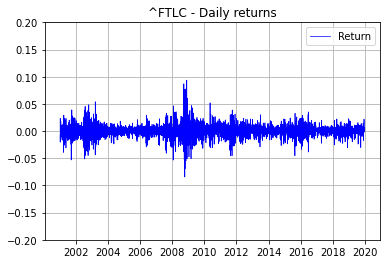

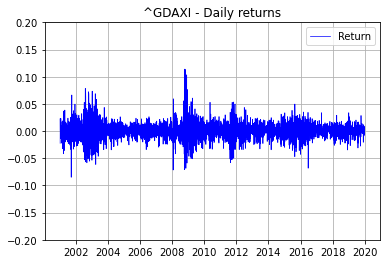

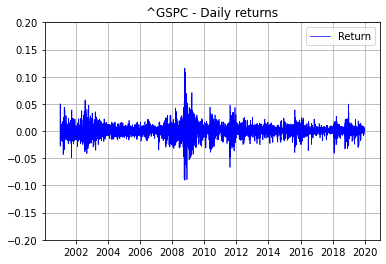

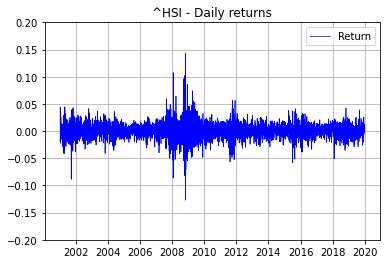

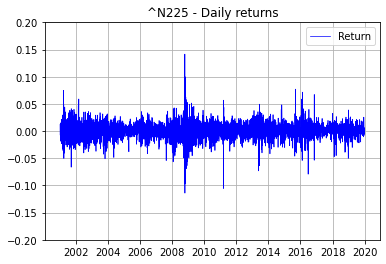

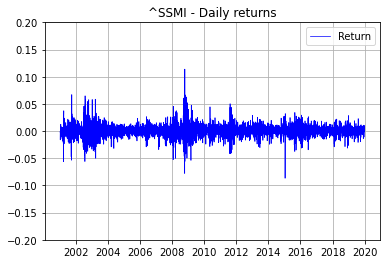

In [23]:
index_grouped = all_index_df.groupby('index')
for name, df in index_grouped:
    df.set_index(df['date'], inplace=True)
    plt.plot(df['price_change'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(name + ' - Daily returns')
    plt.show()

## Drawdown
def: total loss over consequtive days from the last maximum to the next minimum of the price

In [54]:
all_index_df= pd.read_csv("./data/index/all_index.csv")
all_index_df['date'] = pd.to_datetime(all_index_df['date'])

In [55]:
# Create drawdown table
drawdowns_dict = {}
drawdowns_df = []

index_grouped = all_index_df.groupby('index')
for name, index_df in index_grouped:
    index_df = index_df[index_df['date'].dt.year >= 2001] #Only identify drawdown starting from 2001
    index_df.set_index(index_df['date'], inplace=True)
    index_change = index_df['price'].diff()
    drawdowns = []
    drawdown_start = None
    dd = 0
    
    for date, price in zip(index_df.index, index_df['price']):
        if drawdown_start is None and index_change[date] < 0:
            drawdown_start = date
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] <= 0:
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] > 0:
            drawdown_end = date
            duration = (drawdown_end - drawdown_start).days
            drawdown = dd / index_df['price'][drawdown_start]
            drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
            drawdown_start = None
            dd = 0

    # Convert drawdowns list to DataFrame
    drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
    drawdowns_df = drawdowns_df.sort_values(by='drawdown')
    drawdowns_dict[name] = drawdowns_df

print(drawdowns_dict)

{'000001.SS':     drawdown_start drawdown_end  duration  drawdown
874     2015-08-20   2015-08-27         7 -0.236559
441     2008-06-03   2008-06-16        13 -0.171762
866     2015-07-01   2015-07-06         5 -0.145622
865     2015-06-25   2015-06-30         5 -0.140714
462     2008-09-26   2008-10-13        17 -0.129449
..             ...          ...       ...       ...
723     2012-12-19   2012-12-20         1 -0.000104
947     2016-08-29   2016-08-30         1 -0.000092
956     2016-10-20   2016-10-21         1 -0.000085
185     2004-02-19   2004-02-20         1 -0.000047
608     2011-02-25   2011-02-28         3 -0.000013

[1150 rows x 4 columns], '^BSESN':      drawdown_start drawdown_end  duration  drawdown
435      2008-10-22   2008-10-29         7 -0.213751
437      2008-11-11   2008-11-21        10 -0.211912
433      2008-10-03   2008-10-13        10 -0.201801
390      2008-01-14   2008-01-23         9 -0.197679
182      2004-05-14   2004-05-18         4 -0.176397
...     

In [56]:
# Save drawdown to csv 
all_drawdowns_df = pd.DataFrame()
path = "./data/crashes/"
for index, drawdowns_df in drawdowns_dict.items():
    all_drawdowns_df = pd.concat([all_drawdowns_df, drawdowns_df.assign(index=index)], ignore_index=True)

all_drawdowns_df.to_csv(path + f"all_drawdowns.csv", index=False)
print(f"Saved all_drawdowns.csv")

Saved all_drawdowns.csv


## Crashes
- 99.5% percentile of drawdowns
- why not 20% drop?
- change to quarter drop?

In [57]:
# Crash Identification
crashes_dict = {}
for index, dd in drawdowns_dict.items():
    crash_threshold = dd['drawdown'].iloc[round(dd.shape[0] * 0.01)]
    crash_df = dd[dd['drawdown'] < crash_threshold]
    crash_df.columns = ['crash_start', 'crash_end', 'duration','drawdown']
    crashes_dict[index] = crash_df

print(crashes_dict)

{'000001.SS':     crash_start  crash_end  duration  drawdown
874  2015-08-20 2015-08-27         7 -0.236559
441  2008-06-03 2008-06-16        13 -0.171762
866  2015-07-01 2015-07-06         5 -0.145622
865  2015-06-25 2015-06-30         5 -0.140714
462  2008-09-26 2008-10-13        17 -0.129449
464  2008-10-21 2008-10-28         7 -0.127981
418  2008-01-21 2008-01-23         2 -0.126314
427  2008-03-12 2008-03-19         7 -0.122105
29   2001-07-23 2001-08-01         9 -0.119551
365  2007-01-30 2007-02-06         7 -0.113537
869  2015-07-24 2015-07-29         5 -0.113223
453  2008-08-08 2008-08-15         7 -0.111484, '^BSESN':     crash_start  crash_end  duration  drawdown
435  2008-10-22 2008-10-29         7 -0.213751
437  2008-11-11 2008-11-21        10 -0.211912
433  2008-10-03 2008-10-13        10 -0.201801
390  2008-01-14 2008-01-23         9 -0.197679
182  2004-05-14 2004-05-18         4 -0.176397
35   2001-09-05 2001-09-18        13 -0.170545
296  2006-05-18 2006-05-23         

In [58]:
# Save crashes to csv 
all_crashes_df = pd.DataFrame()
path = "./data/crashes/"
for index, crashes_df in crashes_dict.items():
    crashes_df.to_csv(path + f"{index}_crahes.csv", index=False)
    print(f"Saved {index}_crashes.csv")
    crashes_df.loc[:, 'index'] = index
    all_crashes_df = pd.concat([all_crashes_df, crashes_df], ignore_index=True)
    
all_crashes_df.to_csv(path + f"all_crashes.csv", index=False)
print(f"Saved all_crashes.csv")

Saved 000001.SS_crashes.csv
Saved ^BSESN_crashes.csv
Saved ^BVSP_crashes.csv
Saved ^FCHI_crashes.csv
Saved ^FTLC_crashes.csv
Saved ^GDAXI_crashes.csv
Saved ^GSPC_crashes.csv
Saved ^HSI_crashes.csv
Saved ^N225_crashes.csv
Saved ^SSMI_crashes.csv
Saved all_crashes.csv


/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_72294/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [59]:
# Crashes Count
crash_count = 0
for index, crashes_df in crashes_dict.items():
    crash_count += len(crashes_df)
print(crash_count)

121


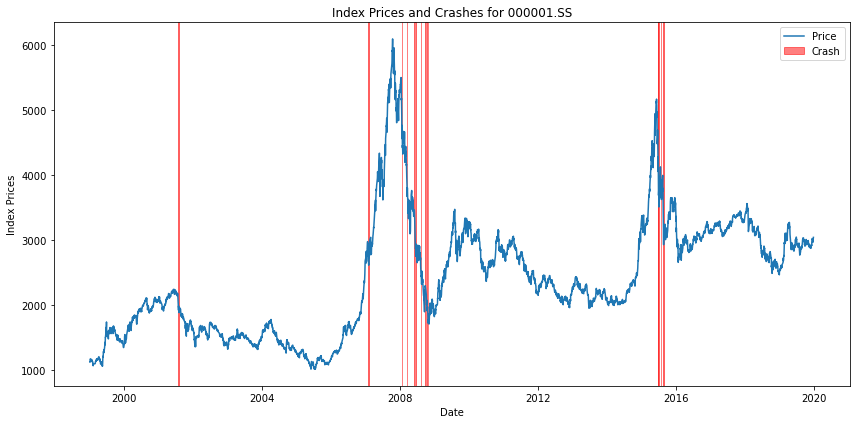

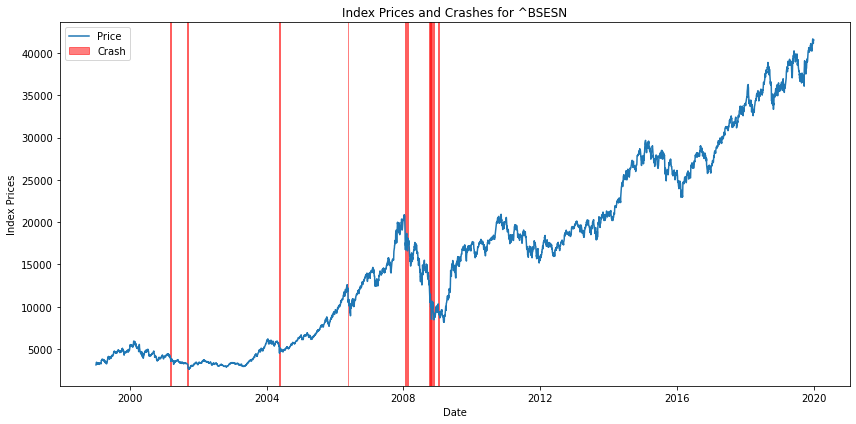

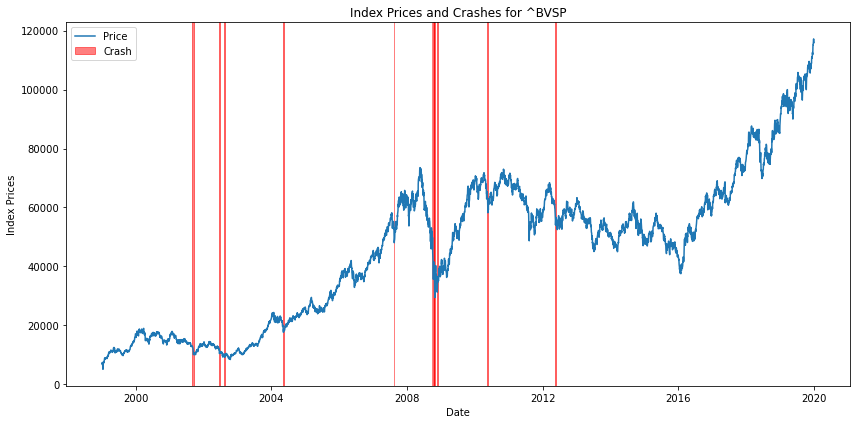

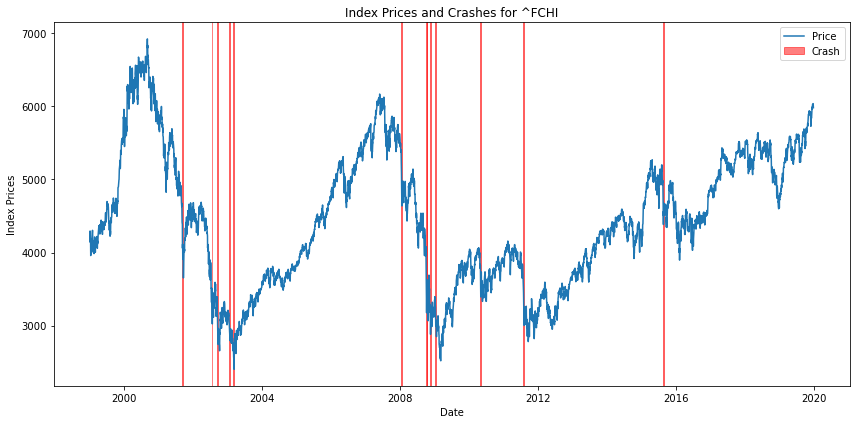

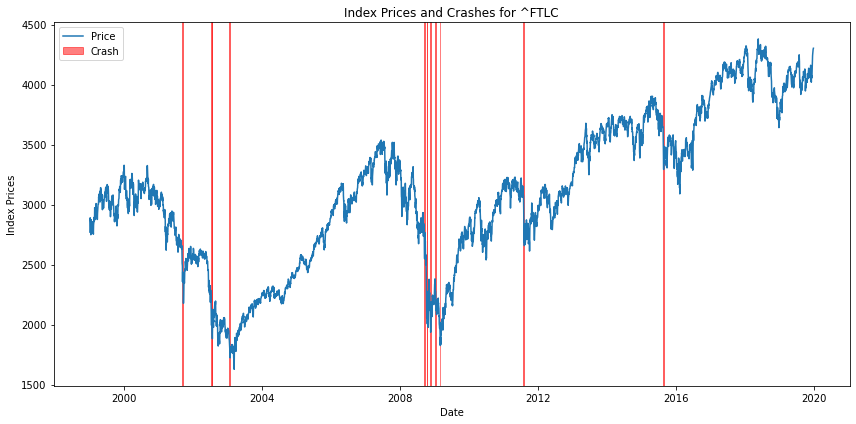

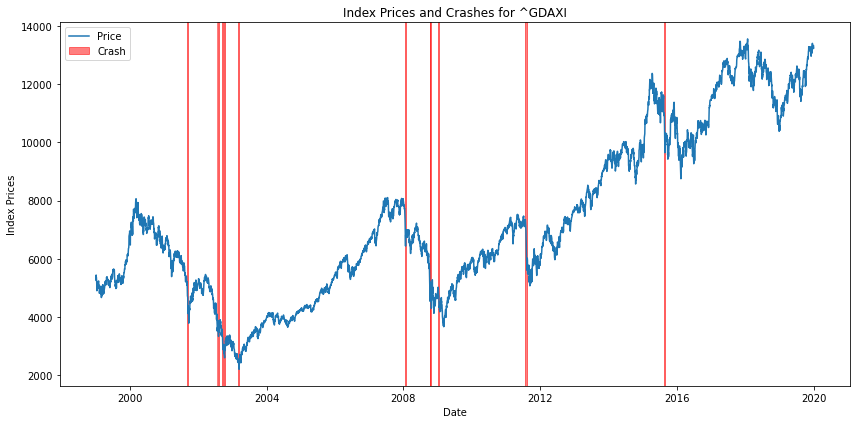

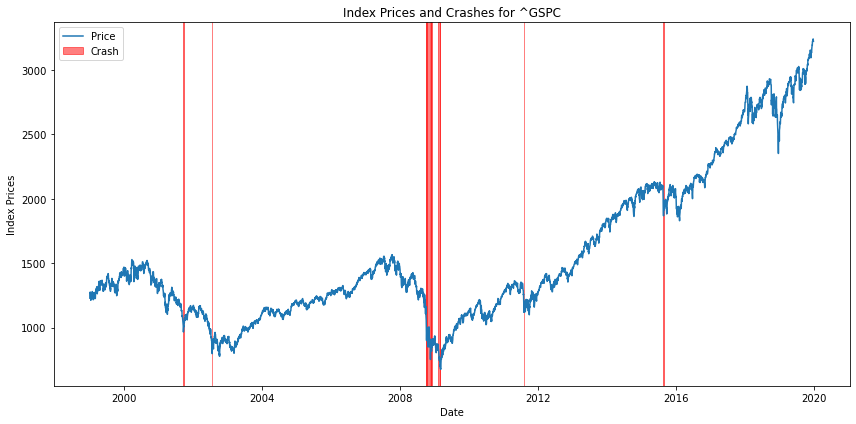

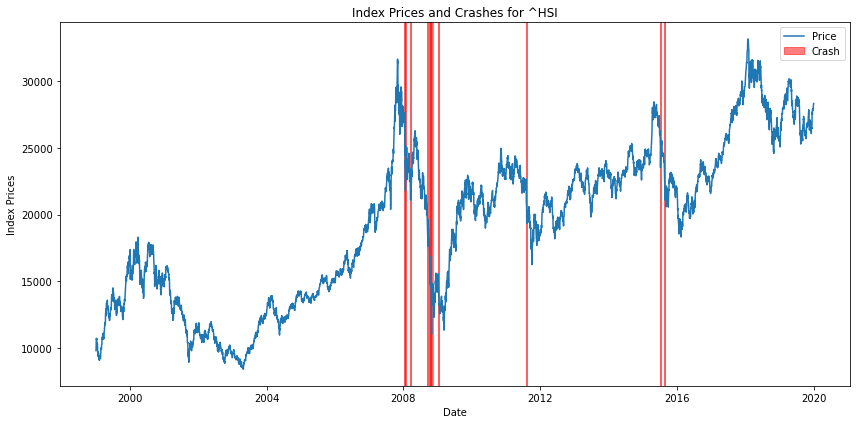

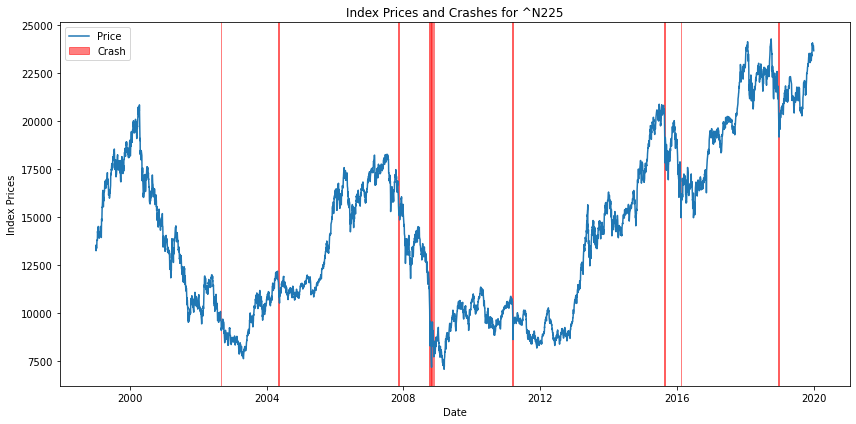

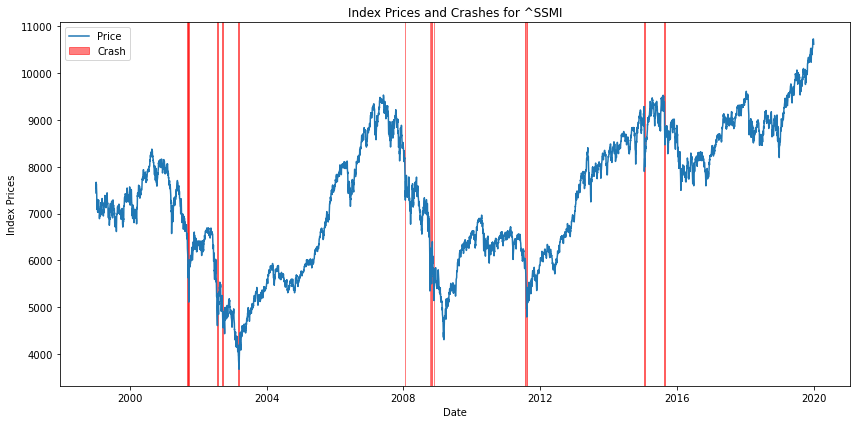

In [60]:
# Plot crashes in graph
index_grouped = all_index_df.groupby('index')
for index, df in index_grouped:
    df.set_index(df['date'], inplace=True)
    index_prices = np.array(df['price'])
    index_dates = np.array(df.index)
    plt.figure(figsize=(12, 6))
    plt.plot(index_dates, index_prices, label=f'{index} Prices')
    
    crashes_df = crashes_dict[index]
    for crash_start, crash_end in zip(crashes_df['crash_start'], crashes_df['crash_end']):
        plt.axvspan(crash_start, crash_end, alpha=0.5, color='red')
    plt.title(f'Index Prices and Crashes for {index}')
    plt.xlabel('Date')
    plt.ylabel('Index Prices')
    plt.legend(['Price', 'Crash'])
    plt.tight_layout()
    plt.show()

## Label the crashes
- we need to label the crashes to each day using all_index_df and all_crashes_df before training them to ML models

In [61]:
# Function to label crashes
def label_crashes(row):
    for index, crash in all_crashes_df.iterrows():
        if crash['crash_start'] <= row['date'] and row['date'] <= crash['crash_end'] and row['index'] == crash['index']:
            return 1
    return 0

# Apply the function to create a new column indicating whether there was a crash
all_index_df['crash_label'] = all_index_df.apply(label_crashes, axis=1)

In [62]:
# View the resulting dataframe
labeled_index_df = all_index_df

# Drop columns
labeled_index_df = labeled_index_df.drop(['price_change', 'volume_change'], axis=1)

In [63]:
# Save as csv
labeled_index_df.to_csv('./data/labeled_data/' + f"daily_labeled_index.csv", index=False)
print(f"Saved daily_labeled_index.csv")

Saved daily_labeled_index.csv


3m, 6m crashes labelling
- Create labels to indicate if crash occurs within next 3 months and 6 months
- To predict a crash on day t, the daily price changes from each day prior to t could be used as a feature

In [69]:
labeled_index_df = pd.read_csv("./data/labeled_data/daily_labeled_index.csv")

In [70]:
# Resample to quarterly data
labeled_index_grouped = labeled_index_df.groupby('index')
quarterly_labeled_index = pd.DataFrame()

for name, df in labeled_index_grouped:
    df['date'] = pd.to_datetime(df['date'])
    quarterly_df = df.set_index('date').resample('Q').agg({
    'price': 'last',
    'volume': 'sum',
    'volatility': 'mean',
    'index': 'last',
    'crash_label': 'any'
    })
    quarterly_df['price_change'] = quarterly_df['price'].pct_change()
    quarterly_df['volume_change'] = quarterly_df['volume'].pct_change()
    quarterly_df['crash_label'] = quarterly_df['crash_label'].astype(int)
    quarterly_df['date'] = quarterly_df.index
    quarterly_labeled_index = pd.concat([quarterly_labeled_index, quarterly_df], ignore_index=True)

In [72]:
quarterly_labeled_index.loc[quarterly_labeled_index['volume'] == 0, 'volume_change'] = 0
quarterly_labeled_index = quarterly_labeled_index.drop(['price', 'volume'], axis=1)
quarterly_labeled_index = quarterly_labeled_index[quarterly_labeled_index['date'].dt.year >= 2001]
quarterly_labeled_index

,volatility,index,crash_label,price_change,volume_change,date
8,150.756673,000001.SS,0,0.018953,0.000000,2001-03-31
9,98.171833,000001.SS,0,0.049818,0.000000,2001-06-30
10,100.911423,000001.SS,1,-0.204308,0.000000,2001-09-30
11,167.611187,000001.SS,0,-0.067368,0.000000,2001-12-31
12,236.729759,000001.SS,0,-0.025557,0.000000,2002-03-31
...,...,...,...,...,...,...
835,275.287884,^SSMI,0,-0.072479,0.344071,2018-12-31
836,223.361272,^SSMI,0,0.124392,-0.064293,2019-03-31
837,324.854218,^SSMI,0,0.044356,-0.030917,2019-06-30
838,424.390936,^SSMI,0,0.018193,0.288380,2019-09-30


In [73]:
# Save as csv
quarterly_labeled_index.to_csv('./data/labeled_data/' + f"quarterly_labeled_index.csv", index=False)
print(f"Saved quarterly_labeled_index.csv")

Saved quarterly_labeled_index.csv


## Standardization

In [106]:
# Handle extreme value
quarterly_labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

In [107]:
# Standardize by index
# from util import z_score_standardization

# quarterly_labeled_index_standardized = pd.DataFrame()
# quarterly_labeled_index_grouped = quarterly_labeled_index.groupby('index')
# for name, df in quarterly_labeled_index_grouped:
#     df['price_change'] = z_score_standardization(df['price_change'])
#     df['volume_change'] = z_score_standardization(df['volume_change'])
#     df['volatility'] = z_score_standardization(df['volatility'])
#     quarterly_labeled_index_standardized = pd.concat([quarterly_labeled_index_standardized, df], ignore_index=True)
    

In [108]:
from util import z_score_standardization

quarterly_labeled_index_standardized = quarterly_labeled_index
quarterly_labeled_index_standardized['price_change'] = z_score_standardization(quarterly_labeled_index_standardized['price_change'])
quarterly_labeled_index_standardized['volume_change'] = z_score_standardization(quarterly_labeled_index_standardized['volume_change'])
quarterly_labeled_index_standardized['volatility'] = z_score_standardization(quarterly_labeled_index_standardized['volatility'])
    

In [115]:
# Save as csv
quarterly_labeled_index_standardized.to_csv('./data/labeled_data/' + f"quarterly_labeled_index_standardized.csv", index=False)
print(f"Saved quarterly_labeled_index_standardized.csv")

Saved quarterly_labeled_index_standardized.csv


In [116]:
quarterly_labeled_index_standardized

,volatility,index,crash_label,price_change,volume_change,date
date,,,,,,
2001-03-31,-0.574964,000001.SS,0,0.021054,-0.131833,2001-03-31
2001-06-30,-0.609984,000001.SS,0,0.305619,-0.131833,2001-06-30
2001-09-30,-0.608159,000001.SS,1,-2.037319,-0.131833,2001-09-30
2001-12-31,-0.563739,000001.SS,0,-0.774788,-0.131833,2001-12-31
2002-03-31,-0.517708,000001.SS,0,-0.389305,-0.131833,2002-03-31
...,...,...,...,...,...,...
2018-12-31,-0.492030,^SSMI,0,-0.821909,-0.131833,2018-12-31
2019-03-31,-0.526611,^SSMI,0,0.993163,-0.131833,2019-03-31
2019-06-30,-0.459020,^SSMI,0,0.255263,-0.131833,2019-06-30


## Dataset imbalances

The rare nature of stock market crash events results in a highly imbalanced dataset. 
Only 0.7% of available sample corresponds to crash events. Imbalanced dataset can influence ML algorithms and biased against the minority class<br>
One of the solutions is apply resampling

In [74]:
print("Total sample size: ", len(quarterly_labeled_index))
print("Sample size of not crash quarter: ", quarterly_labeled_index['crash_label'].value_counts()[0])
print("Sample size of crash quarter: ", quarterly_labeled_index['crash_label'].value_counts()[1])
print("Percentage of quarterly crash: ", quarterly_labeled_index['crash_label'].value_counts()[1]/len(quarterly_labeled_index))

Total sample size:  760
Sample size of not crash quarter:  681
Sample size of crash quarter:  79
Percentage of quarterly crash:  0.10394736842105264
